In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from pandas_profiling import ProfileReport

In [2]:
luftfilter = pd.read_csv("G0046_Luftfilter_Tank1.csv")
pumpe = pd.read_csv("G0046_Pumpendruck_Druckhaltpumpe.csv")
zylinder = pd.read_csv("G0046_Zylinderdruck_1_Pressdruck.csv")
events = pd.read_csv("events.csv")

Es sind Daten von 3 Messstationen vorhanden, sowie ein Log der Events

In [3]:
#Maschinensetillstand & Fehlercode als Faktor
events['MES_Reasoncode'] = events['MES_Reasoncode'].astype(object)

In [4]:
events.head()

,DateTime,KT04_Maschinenstillstand,MES_Reasoncode
0,31.05.2017 06:00:00.0000000,1,620
1,11.07.2017 22:00:00.0000000,1,503
2,12.07.2017 06:00:00.0000000,1,503
3,10.10.2017 06:00:00.0000000,1,503
4,10.10.2017 22:00:00.0000000,1,503


Das Feature MES_Reasoncode ist relevant, um den Grund des Stillstandes zu ermitteln. Es soll ein Maschinenstillstand vorausgesagt werden.

In [5]:
merge1 = pd.merge(luftfilter,pumpe,on="DateTime")
merge2 = pd.merge(zylinder, events,how="outer" ,on="DateTime")

In [6]:
data = pd.merge(merge1,merge2, how="outer",on="DateTime")

In [7]:
data.columns= ["DateTime","Luftfilter","Pumpendruck","Zylinderdruck","Maschinenstillstand","Fehlercode"]
data["Maschinenstillstand"]=data["Maschinenstillstand"].fillna(value=0)
#data['Maschinenstillstand'] = data['Maschinenstillstand'].astype(object)
data['DateTime'] = pd.to_datetime(data.DateTime)

data.head()



,DateTime,Luftfilter,Pumpendruck,Zylinderdruck,Maschinenstillstand,Fehlercode
0,2017-01-01 00:00:00.000,43.0,202.0,136.0,0.0,NaN
1,2017-01-01 23:28:56.339,0.0,216.0,NaN,0.0,NaN
2,2017-01-02 17:42:26.445,34.0,178.0,104.8,0.0,NaN
3,2017-01-02 21:40:16.483,33.0,5.0,NaN,0.0,NaN
4,2017-01-02 23:03:30.499,33.0,5.0,NaN,0.0,NaN


In [8]:
del data['Fehlercode']

In [9]:
data.head()

,DateTime,Luftfilter,Pumpendruck,Zylinderdruck,Maschinenstillstand
0,2017-01-01 00:00:00.000,43.0,202.0,136.0,0.0
1,2017-01-01 23:28:56.339,0.0,216.0,NaN,0.0
2,2017-01-02 17:42:26.445,34.0,178.0,104.8,0.0
3,2017-01-02 21:40:16.483,33.0,5.0,NaN,0.0
4,2017-01-02 23:03:30.499,33.0,5.0,NaN,0.0


In [10]:
data.isna().sum()

DateTime                     0
Luftfilter             2914417
Pumpendruck            2914416
Zylinderdruck            37318
Maschinenstillstand          0
dtype: int64

In [11]:
#data.groupby(pd.Grouper(key='DateTime', freq='720min')).mean().isna().sum()
#data.groupby(pd.Grouper(key='DateTime', freq='720min')).mean()


MemoryError: 

In [ ]:
#data_na.groupby(pd.Grouper(key='DateTime', freq='720min')).mean().count()

In [ ]:
#ProfileReport(data, check_recoded = False)

Überlegung: DateTime ist zu detailiert (Millisekunden & Sekunden), würde man so über DateTime mergen, würde man eine Sparse Matrix mit vielen NAs bekommen.
    
Droppt man alle NAs (außer den Maschinenstillstand), bleibt nur mehr ein Datensatz von 1367 Instanzen übrig. Wegen der sparsen Matrix werden dabei zuviele Daten gedroppt.Dabei werden zuviele Daten

In [12]:
data_na = data
data_na = data_na.dropna(subset=["Luftfilter"])
data_na = data_na.dropna(subset=["Pumpendruck"])
data_na = data_na.dropna(subset=["Zylinderdruck"])

data_na.shape

(1367, 5)

In [13]:
data_na.head()

,DateTime,Luftfilter,Pumpendruck,Zylinderdruck,Maschinenstillstand
0,2017-01-01 00:00:00.000,43.0,202.0,136.0,0.0
2,2017-01-02 17:42:26.445,34.0,178.0,104.8,0.0
6,2017-01-03 13:33:36.544,33.0,6.0,135.2,0.0
7,2017-01-03 22:14:38.575,34.0,178.0,129.6,0.0
10,2017-01-04 03:16:39.600,0.0,6.0,135.2,0.0


Besser, wäre es, DateTime in z.B. 5 Minuten Intervalle zu Binnen, und jeweils den Mittelwert aller Werte innerhalb des Intervalls berechnen.

In [ ]:
data_na['DateTime'] = pd.to_datetime(data_na.DateTime)

#data_na.groupby(pd.Grouper(key='DateTime', freq='30min')).mean().dropna()

In [ ]:
data_na.groupby(pd.Grouper(key='DateTime', freq='720min')).mean()

(736291.2940823918, 737142.8242697726, -26.05, 525.05)

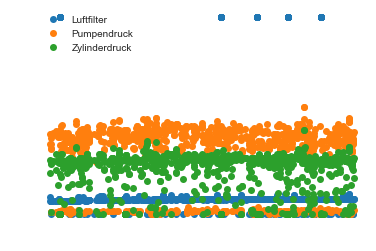

In [15]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot_date(x=data_na.DateTime,y=data_na.Luftfilter,)
plt.plot_date(x=data_na.DateTime,y=data_na.Pumpendruck,)
plt.plot_date(x=data_na.DateTime,y=data_na.Zylinderdruck,)
#plt.plot_date(x=data_na.DateTime,y=data_na.	Maschinenstillstand,)
#plt.axvline(x=data_na.DateTime, y =data_na.Fehlercode)
plt.legend()
plt.axis('off')




In [ ]:
for i in len(data_na.Fehlercode):  
    plt.axvline(x=data_na[i].DateTime, y =data_na[i].Fehlercode)

Plottet man die Messdaten, sieht man, dass die Werte des Luftfilters immer wieder schlagartig ansteigen. Wärend diesen Phasen, werden keine Werte für den Pumpendruck aufgezeichnet. Es könnte sich bei dem plötzlichen Anstieg um einen Zeitreiheneffekt handen, dann müsste man die Werte aller drei Messungen vor dem Anstieg für die Klassifizierung Maschinenstillstand ja/nein betrachtet werden. Dies könnte z.B. mit einem Recurrent Neural Network oder LSTM NN erreicht werden, weil in diesen beiden NN Architekturen Zeitreihen klassifiziert werden können.